# Lab  7 - Bayesian inference with PyMC3.

##### Keywords: beta-binomial, hierarchical, pymc3, posterior predictive

## Contents
{:.no_toc}
* 
{: toc}

## Learning Aims

- Using PyMC3
- Building probability models
- MAP estimates with PyMC3
- Sampling with PyMC3
- Convergence tests
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}$
$\newcommand{\indic}{\mathbb{1}}$
$\newcommand{\avg}{\overline}$
$\newcommand{\est}{\hat}$
$\newcommand{\trueval}[1]{#1^{*}}$
$\newcommand{\Gam}[1]{\mathrm{Gamma}#1}$
## Installing PyMC3

PyMC3 is included in the Anaconda Python distribution. PyMC3 can also be installed using pip:

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import pandas as pd

import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal
import time

# Tumors in rats

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using Gibbs sampling in a previous lab. Remember that the goal is to estimate $\theta$, the probability of developing a tumor in a population of female rats that have not received treatement. Data of a particular experiment shows that 4 out of 14 rats develop the tumor. But we also have historical literature data for other 70 experiments, which give estimates $\theta_i$. 

For convenience, we adopt a prior for $\theta_i$ from the conjugate *Beta* family: $\theta_i \sim Beta(\alpha, \beta)$. If we had an expert telling us the values for $\alpha$ and $\beta$, we could just calculate the posterior using the conjugate rules. But we do not usually have that. We have, instead, the historical data, that we can use to perform inference for $\theta_i$, the tumor probability in the current experiment

It is natural the model the number $y_i$ of tumors for *each* experiment performed on a total of $n_i$ rats as a binomial:

$$
p(y_i \vert \theta_i; n_i) =  Binom(n_i, y_i, \theta_i)
$$

We can now write a joint posterior distribution for the $\theta$s, $\alpha$ and $\beta$, assuming partial pooling (i.e., hierarchical Bayes), where the $\theta_i$ is assumed to be different for each experiment, but all drawn from the same *Beta* distribution with parameteres $\alpha$ and $\beta$:

$$p( \theta_i, \alpha, \beta  \vert  y_i, n_i) \propto p(\alpha, \beta) \, p(\theta_i  \vert  \alpha, \beta) \, p(y_i  \vert  \theta_i, n_i,\alpha, \beta)$$
or for the whole dataset:
$$ p( \Theta, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

So we only need to figure out the prior for the hyperparameters: $p(\alpha,\beta)$. We have shown that it is convenient to use uniform priors on the alernative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}$$
$$\nu = (\alpha+\beta)^{-1/2}$$

which yiels a prior for $\alpha$ and $\beta$ of the form:

$$p(\alpha,\beta) \sim (\alpha+\beta)^{-5/2}$$

Let us firs load the data:

In [2]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

And now let us create two arrays, one for the observed tumors and one for the total number of rats in each of the 70 experiments.

In [3]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
print(tumory, tumorn)
print(np.shape(tumory))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  3  2  2
  2  2  2  2  2  2  2  1  5  2  5  2  7  7  3  3  2  9 10  4  4  4  4  4  4
  4 10  4  4  4  5 11 12  5  5  6  5  6  6  6  6 16 15 15  9] [20 20 20 20 20 20 20 19 19 19 19 18 18 17 20 20 20 20 19 19 18 18 27 25 24
 23 20 20 20 20 20 20 10 49 19 46 17 49 47 20 20 13 48 50 20 20 20 20 20 20
 20 48 19 19 19 22 46 49 20 20 23 19 22 20 20 20 52 46 47 24]
(70,)


Just to have some intuition let us get the naive probabilities ($y_i/n_i$) of developing a tumor for each of the 70 experiments, and let's print the mean and the standard deviation:

In [4]:
tumor_rat = [float(e[0])/float(e[1]) for e in zip(tumory, tumorn)]
#print (tumor_rat)
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
print(tmean, tvar)

0.13600653889 0.0105576406236


We now write the model in PyMC3. PyMC3 will by default use the NUTS algorithm, unless told otherwise. Once the step method has been chosen, PyMC3 will also optimize for the parameters of the method (step sizes, proposal distributions, scaling, starting values for the parameters, etc), but we can also manually set those. Here we use both NUTS and Metropolis to perform the sampling. First let us load the relevant probability distributions

### Setting up the PyMC3 model

Now let us set up the model. Note the simplification with respect to the Gibbs sampler we have used earlier. Because PyMC3 takes care of refining the parameters of the selected step method, or uses gradient-based methods for the sampling, it does not require us to specify the conditionals distributions for $\alpha$ and $\beta$. We only need to specify the priors for $\mu$ and $\nu$, and then write expressions for $\alpha$ and $\beta$ as a function of $\mu$ and $\nu$. Note that we use the ```pm.Deterministic``` function to define $\alpha$ and $\beta$ and give them proper names. Without a name, these variables will not be included in the trace.

In [5]:
# pymc3
from pymc3 import Uniform, Normal, Binomial, Beta, sample, Model # Import relevant distributions

N = tumorn.shape[0]

with Model() as tumor_model:

    # Uniform priors on the mean and variance of the Beta distributions
    mu = Uniform("mu",0.00001,1.)
    nu = Uniform("nu",0.00001,1.)

    # Calculate hyperparameters alpha and beta as a function of mu and nu
    alpha = pm.Deterministic('alpha', mu/(nu*nu))
    beta = pm.Deterministic('beta', (1.-mu)/(nu*nu))
    
    # Priors for each theta
    thetas = Beta('theta', alpha, beta, shape=N)
    
    # Data likelihood
    obs_deaths = Binomial('obs_deaths', n=tumorn, p=thetas, observed=tumory)

In [7]:
from pymc3 import find_MAP

with tumor_model:
    
    #obtain starting values via MAP
    start = find_MAP(model=tumor_model)
    
    # instantiate sampler
    step = pm.Metropolis()
    
    # draw 2000 posterior samples
    tumor_trace = pm.sample(500000, step=step, start=start)

         Current function value: -482.835291
         Iterations: 229
         Function evaluations: 504
         Gradient evaluations: 492


100%|██████████| 500000/500000 [03:05<00:00, 2692.40it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1196dc1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11892b0f0>]], dtype=object)

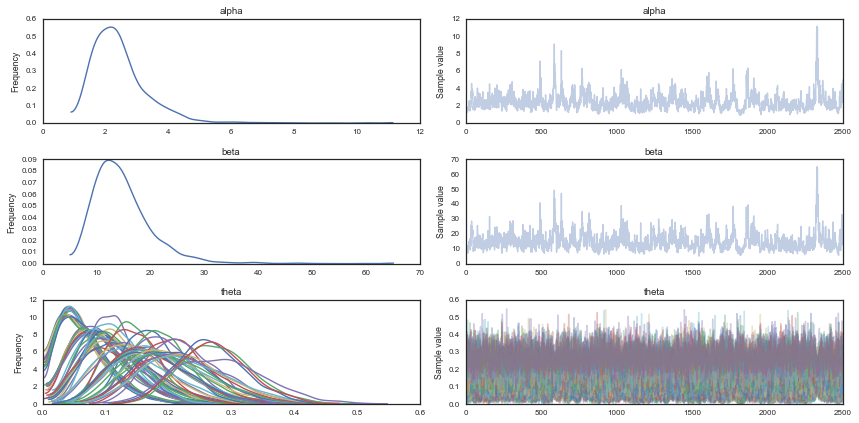

In [8]:
from pymc3 import traceplot

traceplot(tumor_trace[250000::100], varnames=['alpha','beta','theta'])

I have used the first half of the original samples for burnin. Note that we need many iterations, and a significant amount of thinning in order to make it converge and have uncorrelated samples. We plot the $\alpha$ and $\beta$ marginals and create a 2D histogram or KDE plot (sns.kdeplot in seaborn) of the marginal posterior density in the space $x = \alpha/\beta$, $y = log(\alpha + \beta)$. Further down we also look at the autocorrelation plots for $\alpha$, $\beta$, and $\theta_1$.

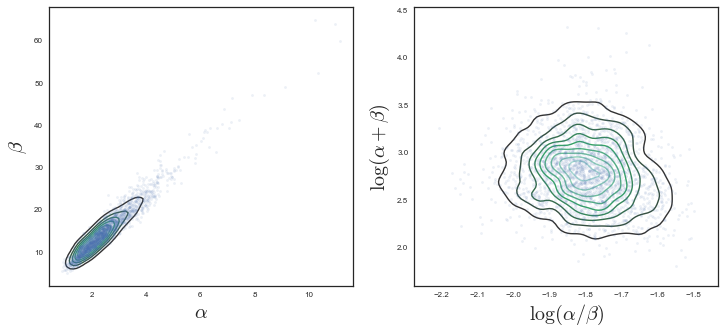

In [11]:
fig = plt.subplots(1, 2, figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(tumor_trace['alpha'][250000::100], tumor_trace['beta'][250000::100],'.', alpha=0.1)
sns.kdeplot(tumor_trace['alpha'][250000::100], tumor_trace['beta'][250000::100])
plt.xlabel(r"$\alpha$",size=20)
plt.ylabel(r"$\beta$",size=20)
plt.subplot(1,2,2)
plt.plot(np.log(tumor_trace['alpha'][250000::100]/tumor_trace['beta'][250000::100]), np.log(tumor_trace['alpha'][250000::100]+tumor_trace['beta'][250000::100]),'.', alpha=0.1)
sns.kdeplot(np.log(tumor_trace['alpha'][250000::100]/tumor_trace['beta'][250000::100]), np.log(tumor_trace['alpha'][250000::100]+tumor_trace['beta'][250000::100]))
plt.xlabel(r"$\log(\alpha/\beta)$",size=20)
plt.ylabel(r"$\log(\alpha+\beta)$",size=20)

#### Autocorrelation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14080f8d0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x13fc50438>]], dtype=object)

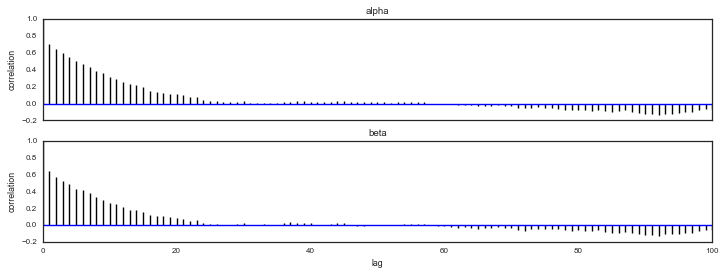

In [12]:
pm.autocorrplot(tumor_trace[250000::100],varnames=['alpha','beta'])

#### NUTS

Let's try with NUTS now:

In [13]:
with tumor_model:
    # Use ADVI for initialization
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=tumor_model.dict_to_array(sds)**2, 
                   is_cov=True)
    tumor_trace = pm.sample(5000, step, start=mu)

100%|██████████| 5000/5000 [00:16<00:00, 298.01it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119058a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119f76e80>]], dtype=object)

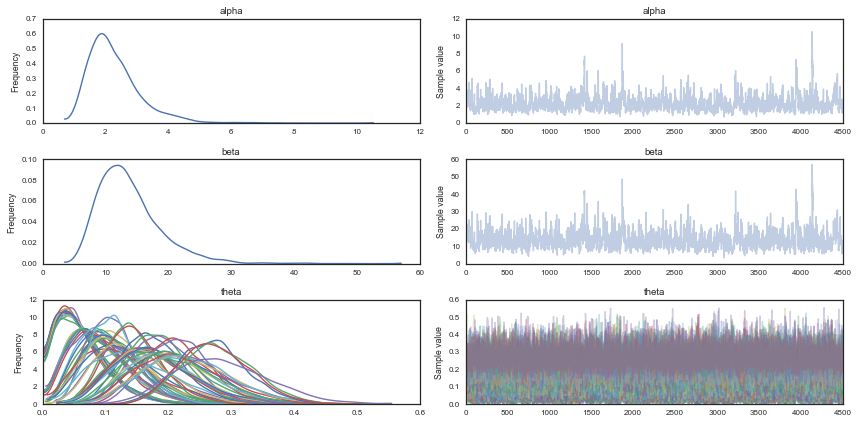

In [14]:
from pymc3 import traceplot

#traceplot(bioassay_trace[500:], varnames=['alpha'])
traceplot(tumor_trace[500:], varnames=['alpha','beta','theta'])

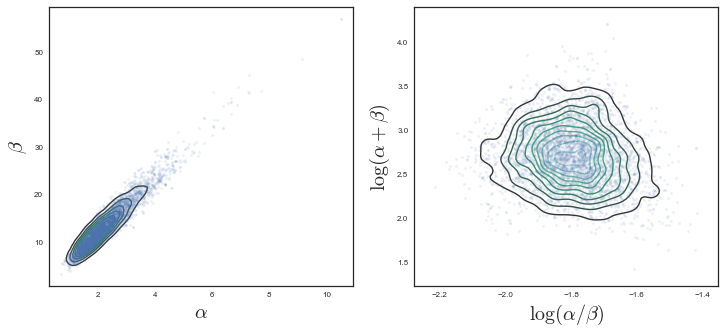

In [15]:
fig = plt.subplots(1, 2, figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(tumor_trace['alpha'][500:], tumor_trace['beta'][500:],'.', alpha=0.1)
sns.kdeplot(tumor_trace['alpha'][500:], tumor_trace['beta'][500:])
plt.xlabel(r"$\alpha$",size=20)
plt.ylabel(r"$\beta$",size=20)
plt.subplot(1,2,2)
plt.plot(np.log(tumor_trace['alpha'][500:]/tumor_trace['beta'][500:]), np.log(tumor_trace['alpha'][500:]+tumor_trace['beta'][500:]),'.', alpha=0.1)
sns.kdeplot(np.log(tumor_trace['alpha'][500:]/tumor_trace['beta'][500:]), np.log(tumor_trace['alpha'][500:]+tumor_trace['beta'][500:]))
plt.xlabel(r"$\log(\alpha/\beta)$",size=20)
plt.ylabel(r"$\log(\alpha+\beta)$",size=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118fd8710>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x119391588>]], dtype=object)

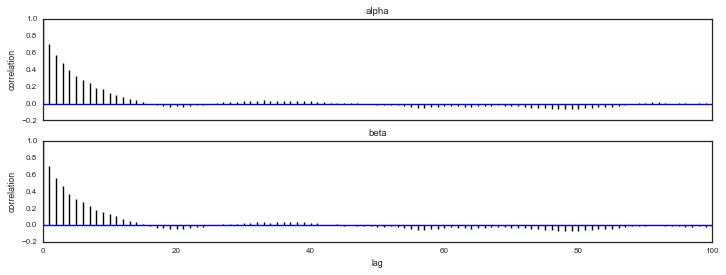

In [16]:
pm.autocorrplot(tumor_trace[500:],varnames=['alpha','beta'])

Note the advantage of using gradients for sampling (stay tuned for Hamiltonian Monte Carlo). We need way less samples to converge to a similar result as with Metropolis, and autocorrelation plots look beter. Let us move to checking convergence for the NUTS sampler, using the Geweke diagnostic. It is important to check that both $\alpha$ and $\beta$ has converged.

In [18]:
from pymc3 import geweke
z = geweke(tumor_trace[500:], intervals=15)

(0, 1000)

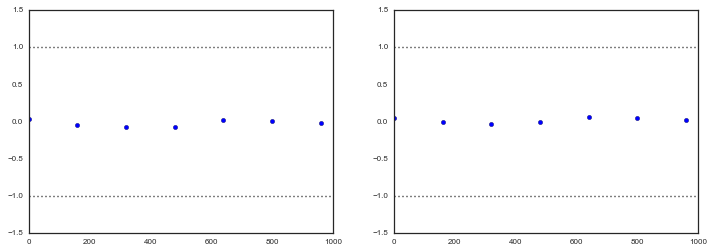

In [19]:
fig = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(*z['alpha'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
plt.subplot(1,2,2)
plt.scatter(*z['beta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

In [21]:
from pymc3 import sample_ppc
with tumor_model:
    tumor_sim = sample_ppc(tumor_trace[500:], samples=500)

100%|██████████| 500/500 [00:01<00:00, 376.61it/s]


Let's plot a few of the posterior predictives and the observed data:

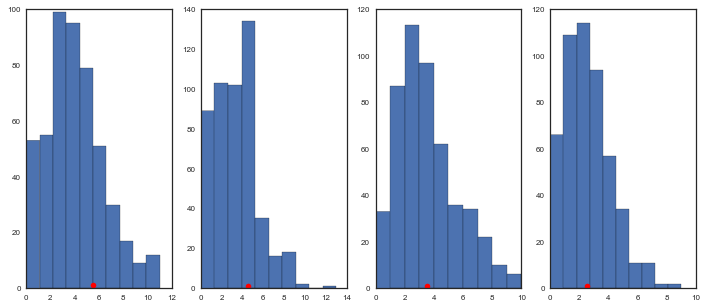

In [24]:
fig = plt.subplots(1, 4, figsize=(12, 5))
plt.subplot(1,4,1)
plt.hist(tumor_sim['obs_deaths'].T[59])
plt.plot(tumory[59]+0.5, 1, 'ro')
plt.subplot(1,4,2)
plt.hist(tumor_sim['obs_deaths'].T[49])
plt.plot(tumory[49]+0.5, 1, 'ro')
plt.subplot(1,4,3)
plt.hist(tumor_sim['obs_deaths'].T[39])
plt.plot(tumory[39]+0.5, 1, 'ro')
plt.subplot(1,4,4)
plt.hist(tumor_sim['obs_deaths'].T[29])
plt.plot(tumory[29]+0.5, 1, 'ro')

A more meaningful plot is the observed tumor rates on the x-axis against posterior medians for each of the 70 $\theta$'s on the y axis, along with error bars obtained from finding the 2.5 and 97.5 percentiles. With ```df_summary``` we can get the summary with the means and the percentiles directly into a pandas dataframe:

In [25]:
from pymc3 import df_summary

df_sum = df_summary(tumor_trace[500:], varnames=['theta'])

In [26]:
medianthetas = df_sum['mean'].values
lowerthetas = df_sum['hpd_2.5'].values
upperthetas = df_sum['hpd_97.5'].values

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

Our naive, non-Bayesian estimate of the probabilities would have been just the ratio of rats with tumor to total number of observed rats in each experiment:

In [28]:
ratios=tumory.astype(float)/tumorn

Now let us compare those naive estimates to our posterior estimates:

(-0.1, 0.5)

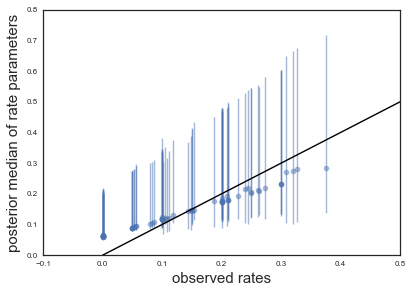

In [29]:
plt.errorbar(ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates",size=15)
plt.ylabel("posterior median of rate parameters",size=15)

plt.xlim(-0.1,0.5)

## The 71st experiment

In a hierarchical model, there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $\tilde{y}$ given a $\theta_i$, and (2) The distribution of observations $\tilde{y}$ drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).
We wish to understand what happens for the 'future' $\theta_{71}$.
We finally, compute the posterior prediction for the 71st experiment.

To do this remember the conditional structure of our problem. $\theta_71$'s parents in the graph are $\alpha$ and $\beta$ so it suffices to sample from them (marginalize over them) to get the $\theta_71$ posterior.

$$
p(\theta_{71},\theta_{1...70},\alpha,\beta \vert D) \propto p(y_{71} \vert n_{71},\theta_{71})p(\theta_{71} \vert \alpha,\beta)p(\theta_{1...70},\alpha,\beta \vert D)
$$

In other words the full posterior so far (for the 70 experiments) becomes the new prior for experiment 71. We need to mix in a prior for θ71θ71 as well, and then the likelihoof for y71y71. Then we simply marginalize over everything to get the θ71θ71 posterior.

In [30]:
p71=np.empty((1000,3000))
combpdf=np.zeros(1000)
xra=np.linspace(0.,1.,1000)
for i in range(3000):
    p71[:,i] = stats.beta.pdf(xra, tumor_trace['alpha'][500:][i]+4, tumor_trace['beta'][500:][i]+10)
for j in range(1000):
    combpdf[j] = combpdf[j] + p71[j,:].sum()
p71.shape, p71[2,:].shape

((1000, 3000), (3000,))

(-0.1, 0.6)

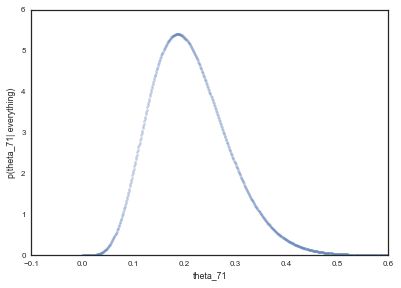

In [31]:
plt.plot(xra, combpdf/3000., '.', alpha=0.3)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71 \vert  everything)')
plt.xlim([-.1,.6])

There is a very critical observation to be made in the calculation above. Notice that this posterior calculation IS NOT a bayesian updating. Neither $\theta_{1:70}$ or $\alpha$ and $\beta$ have been updated to take into account the new data. In this sense we are simply using the parameters in a non-online, supervised mode. Below we redo our MCMC with the new data to get updated parameter estimates.

In [32]:
N = tumorn.shape[0]

with Model() as tumor_model_new:

    # Uniform priors on the mean and variance of the Beta distributions
    mu_new = Uniform("mu_new",0.00001,1.)
    nu_new = Uniform("nu_new",0.00001,1.)

    # Calculate hyperparameters alpha and beta as a function of mu and nu
    alpha_new = pm.Deterministic('alpha_new', mu_new/(nu_new*nu_new))
    beta_new = pm.Deterministic('beta_new', (1.-mu_new)/(nu_new*nu_new))
    
    # Priors for each theta
    thetas_new = Beta('theta_new', alpha_new, beta_new, shape=N+1)
    
    # Data likelihood
    obs_deaths_new = Binomial('obs_deaths_new', n=np.concatenate((tumorn,np.array([14])),axis=0), 
                          p=thetas_new, observed=np.concatenate((tumory,np.array([4])),axis=0))

In [33]:
with tumor_model_new:
    # Use ADVI for initialization
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=tumor_model_new.dict_to_array(sds)**2, 
                   is_cov=True)
    tumor_trace_new = pm.sample(10000, step, start=mu)

100%|██████████| 10000/10000 [00:25<00:00, 387.22it/s]


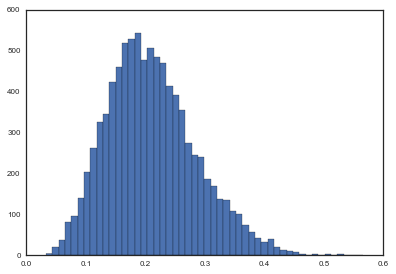

In [34]:
p71 = plt.hist(tumor_trace_new['theta_new'][1000:,70],bins=50)

Note the similarity to the posterior calcuated exactly using the Beta function.